# Load Stuff

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import cv2
import neural_structured_learning as nsl

In [2]:
classes = {
    0: ("actinic keratoses and intraepithelial carcinomae(Cancer)"),
    1: ("basal cell carcinoma(Cancer)"),
    2: ("benign keratosis-like lesions(Non-Cancerous)"),
    3: ("dermatofibroma(Non-Cancerous)"),
    4: ("melanocytic nevi(Non-Cancerous)"),
    5: ("pyogenic granulomas and hemorrhage(Can lead to cancer)"),
    6: ("melanoma(Cancer)"),
}

In [3]:
# Paths
train_path = "dataset\\hmnist_28_28_RGB_train.csv"
test_path = "dataset\\hmnist_28_28_RGB_test.csv"

comp_train_path = "dataset\\hmnist_28_28_RGB_train_0e055_2.csv"
comp_test_path = "dataset\\hmnist_28_28_RGB_test_0e055_2.csv"

main_model_path = 'adv_trained_model.h5'
# main_model_path = 'best_model.h5'
defended_model_path = 'adv_model_defended.h5'

In [4]:
# Load train and test set into X and Y
train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

y_train = train_set['label']
x_train = train_set.drop(columns=['label'])
x_train=np.array(x_train).reshape(-1,28,28,3)

y_test = test_set['label']
x_test = test_set.drop(columns=['label'])
x_test=np.array(x_test).reshape(-1,28,28,3)


In [5]:
# Load the pre-trained model
model = keras.models.load_model(main_model_path)
model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])





Test loss: 1.390673279762268
Test accuracy (%): 72.24164009094238


In [6]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

# Attack

### Function to Make Pertubated Images 

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_compromised_image(image, epsilon, model_to_attack):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model_to_attack(image)
        label = tf.argmax(prediction, axis=1)
        loss = loss_object(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient)

    adversarial_image = image + epsilon*perturbations
    return adversarial_image


### Test Out Attack

1/1 [==============================] - 0s 198ms/step


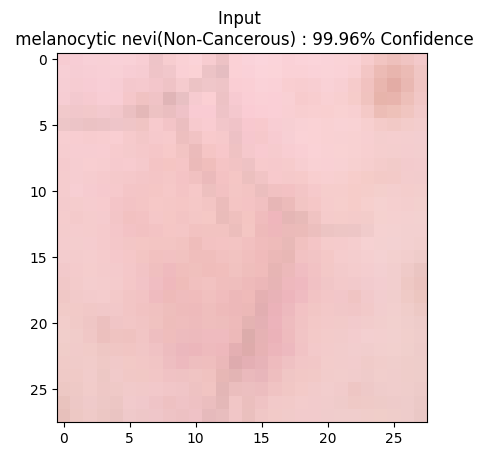

1/1 [==============================] - 0s 27ms/step


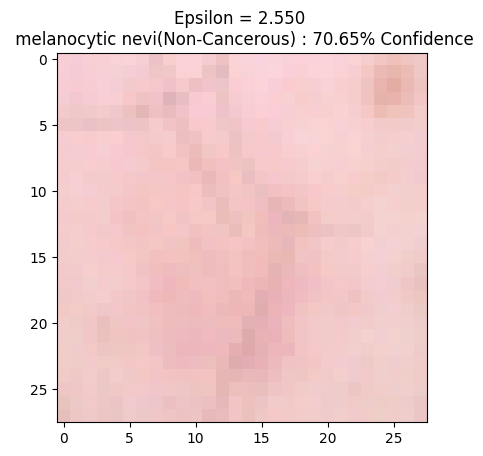

1/1 [==============================] - 0s 30ms/step


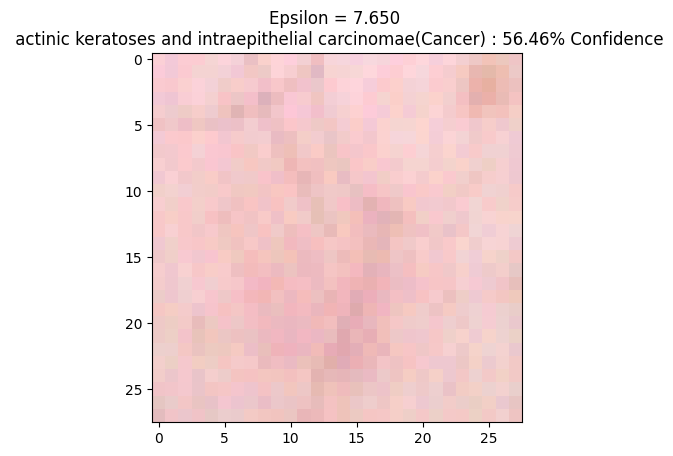

1/1 [==============================] - 0s 25ms/step


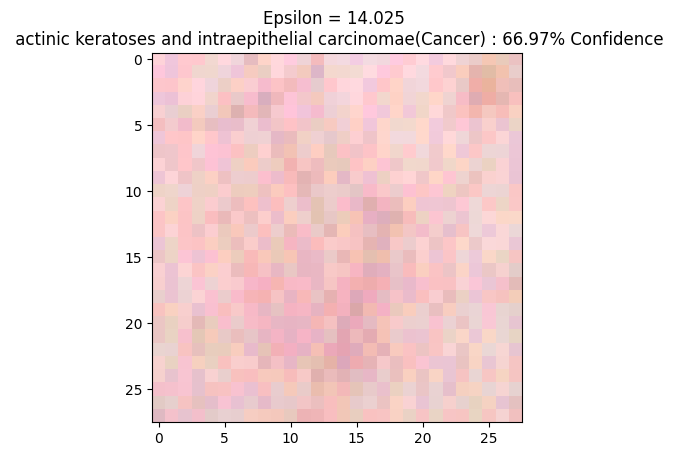

In [42]:
def display_images(new_image, description, model = model):
    #  Display the given image along with its predicted label and confidence.
    pred = model.predict(new_image)
    label = np.argmax(pred, axis=1)[0]
    label = classes[label]
    confidence = np.max(pred, axis=1)[0]
    plt.figure()
    plt.imshow(new_image[0]*0.5/255+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

epsilons = np.array([0, 0.01, 0.03, 0.055])*255
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = create_compromised_image(x_test[0], eps, model)
    display_images(adv_x, descriptions[i])

### Test Attack on multiple images and plot the accuracy for different epsilons

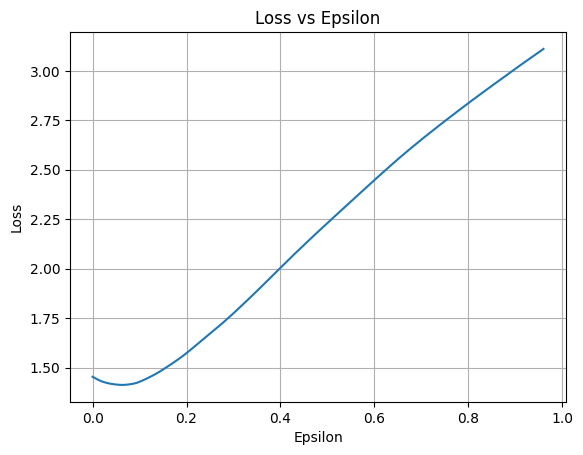

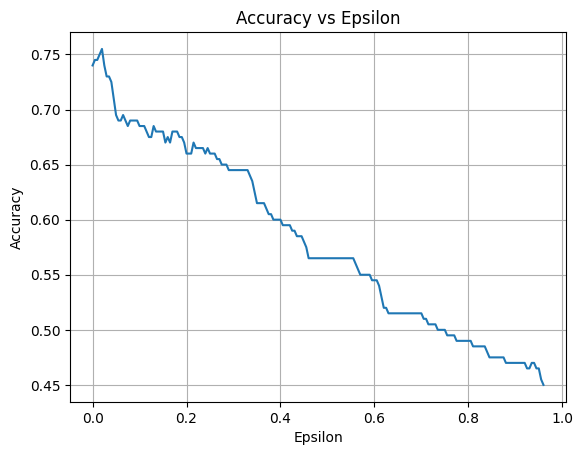

In [32]:
def epsilon_iter_attack(epsilon, model = model, length = 20):
    test_loss = []
    test_acc = []

    for eps in epsilon:
        x_test_compromised = []
        for i, img in enumerate(x_test[:length]):
            adv_x = create_compromised_image(img, eps, model)[0].numpy()
            x_test_compromised.append(adv_x)

        x_test_compromised = np.array(x_test_compromised)
        score = model.evaluate(x_test_compromised, y_test[:length], verbose=0, batch_size=1)
        test_loss.append(score[0])
        test_acc.append(score[1])
    return test_loss, test_acc

# epsilon = np.arange(0, 245/255, 0.005)
# test_loss, test_acc = epsilon_iter_attack(epsilon, length=200, model=model)

# plt.figure()
# plt.plot(epsilon, test_loss)
# plt.title('Loss vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Loss')
# plt.grid()
# plt.show()

# plt.figure()
# plt.plot(epsilon, test_acc)
# plt.title('Accuracy vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Accuracy')
# plt.grid()
# plt.show()

### Make Equivalent CSV file of Pertubated Images

In [29]:
def make_and_store_pertubated_images(og_path, comp_path, epsilon, model = model):

    og_df=pd.read_csv(og_path)

    labels = og_df['label']
    og_img = og_df.drop(columns=['label'])
    og_img=np.array(og_img).reshape(-1,28,28,3)

    # Create compromised dataset
    compromised_img = []
    epsilon = 0.055
    for i, img in enumerate(og_img):
        adv_x = create_compromised_image(img, epsilon*255, model).numpy()
        compromised_img.append(adv_x)
    compromised_img = np.array(compromised_img)

    # Evaluate compromised dataset
    score = model.evaluate(compromised_img, labels, verbose=0, batch_size=1)
    print('Test loss:', score[0])
    print('Test accuracy (%):', 100*score[1])

    # Save as csv
    compromised_img = compromised_img.reshape(-1, 28*28*3)
    compromised_img_with_labels = np.concatenate((compromised_img, np.array(labels)[:, None]), axis=1)
    comp_df = pd.DataFrame(compromised_img_with_labels)
    comp_df.columns = og_df.columns
    comp_df.to_csv(comp_path, index=False)


make_and_store_pertubated_images(train_path, comp_train_path, 0.055, model=model)
make_and_store_pertubated_images(test_path, comp_test_path, 0.055, model=model)

Test loss: 8.48311710357666
Test accuracy (%): 9.922616183757782
Test loss: 8.087944984436035
Test accuracy (%): 16.375437378883362


# Defence

### Load and Mix Pertubated Images With Normal images

In [28]:
og_train_df = pd.read_csv(train_path)
comp_train_df = pd.read_csv(comp_train_path)

og_test_df = pd.read_csv(test_path)
comp_test_df = pd.read_csv(comp_test_path)


# Merge the two datasets
merged_train_df = pd.concat([og_train_df, comp_train_df], ignore_index=True)
merged_test_df = pd.concat([og_test_df, comp_test_df], ignore_index=True)

# Shuffle the datasets
merged_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
merged_test_df = merged_test_df.sample(frac=1).reset_index(drop=True)

# Print the number of samples in each dataset
print("Number of samples in train set: {}".format(len(merged_train_df)))
print("Number of samples in test set: {}".format(len(merged_test_df)))

# Prepare images and labels
y_train_merged = merged_train_df['label']
x_train_merged = merged_train_df.drop(columns=['label'])

y_test_merged = merged_test_df['label']
x_test_merged = merged_test_df.drop(columns=['label'])

y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])

# Oversample the train set
oversample = RandomOverSampler()
x_train_merged,y_train_merged  = oversample.fit_resample(x_train_merged,y_train_merged)

# Reshape the train and test sets
x_train_merged = np.array(x_train_merged).reshape(-1,28,28,3)
x_test_merged = np.array(x_test_merged).reshape(-1,28,28,3)
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\hmnist_28_28_RGB_train_0e055_2.csv'

### Adversarial Training

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=defended_model_path,
                                              monitor='val_accuracy', 
                                              mode='max',
                                              verbose=1,
                                              save_best_only=True)

defended_model = tf.keras.models.clone_model(model)
defended_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

defended_model.fit(x_train_merged, y_train_merged, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])
defended_model = keras.models.load_model(defended_model_path)

Epoch 1/10
1871/1871 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.6559
Epoch 1: val_accuracy improved from -inf to 0.38325, saving model to best_model_defended.h5
1871/1871 [==============================] - 46s 22ms/step - loss: 0.9566 - accuracy: 0.6559 - val_loss: 1.5920 - val_accuracy: 0.3833
Epoch 2/10
   1/1871 [..............................] - ETA: 25s - loss: 0.5050 - accuracy: 0.8125

C:\Users\zengo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1870/1871 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8821
Epoch 2: val_accuracy improved from 0.38325 to 0.62323, saving model to best_model_defended.h5
1871/1871 [==============================] - 36s 19ms/step - loss: 0.3479 - accuracy: 0.8821 - val_loss: 0.8832 - val_accuracy: 0.6232
Epoch 3/10
1870/1871 [============================>.] - ETA: 0s - loss: 0.2401 - accuracy: 0.9196
Epoch 3: val_accuracy did not improve from 0.62323
1871/1871 [==============================] - 35s 19ms/step - loss: 0.2401 - accuracy: 0.9196 - val_loss: 0.9742 - val_accuracy: 0.6051
Epoch 4/10
1868/1871 [============================>.] - ETA: 0s - loss: 0.1811 - accuracy: 0.9391
Epoch 4: val_accuracy did not improve from 0.62323
1871/1871 [==============================] - 35s 19ms/step - loss: 0.1811 - accuracy: 0.9391 - val_loss: 1.0820 - val_accuracy: 0.5089
Epoch 5/10
1870/1871 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9498
Epoch 5: val_accu

### Filter Input Defence

In [ ]:
def average_filter(img):
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(img,-1,kernel)

### Test Defended Model 

In [ ]:
print('Original dataset:')
score_og = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)
print('\nCompromised dataset:')
score_og = model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


x_test_compromised_filtered = np.array([average_filter(img) for img in x_test_compromised])
print('\nCompromised dataset filtered:')
score_og = model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


# rot_img = np.array([np.rot90(img, 2) for img in x_test_compromised])
# print('\nCompromised dataset rotated 180 deg:')
# score_og = model.evaluate(rot_img, y_test_compromised, verbose=0, batch_size=1)
# score_defend = defended_model.evaluate(rot_img, y_test_compromised, verbose=0, batch_size=1)
# score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
# print(score_df)


print('\nMerged dataset:')
score_og = model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)

# Defence 2

In [ ]:
val_ratio = 0.85
val_split_index = int(len(x_train)*val_ratio)

train_data = tf.data.Dataset.from_tensor_slices(
    {'input': x_train[:val_split_index], 'label': y_train[:val_split_index]}).batch(32)
val_data = tf.data.Dataset.from_tensor_slices(
    {'input': x_train[val_split_index:], 'label': y_train[val_split_index:]}).batch(32)
val_steps = x_train[val_split_index:].shape[0] / 32



adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, label_keys=['label'], adv_config = adv_config)
callback = tf.keras.callbacks.ModelCheckpoint(filepath='adv_trained_model.h5',
                                              monitor='val_sparse_categorical_accuracy', 
                                              mode='max',
                                              verbose=1,
                                              save_best_only=True)

adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



adv_model.fit(train_data, validation_data=val_data,
              validation_steps=val_steps, epochs=2, verbose=1, callbacks=[callback])
adv_model = keras.models.load_model(defended_model_path)

score = adv_model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])

Epoch 1/2
210/213 [============================>.] - ETA: 0s - loss: 0.1046 - sparse_categorical_crossentropy: 0.0872 - sparse_categorical_accuracy: 0.9719 - scaled_adversarial_loss: 0.0173
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.84359, saving model to adv_trained_model.h5
213/213 [==============================] - 9s 21ms/step - loss: 0.1062 - sparse_categorical_crossentropy: 0.0887 - sparse_categorical_accuracy: 0.9715 - scaled_adversarial_loss: 0.0176 - val_loss: 0.6971 - val_sparse_categorical_crossentropy: 0.5809 - val_sparse_categorical_accuracy: 0.8436 - val_scaled_adversarial_loss: 0.1162
Epoch 2/2
  7/213 [..............................] - ETA: 3s - loss: 0.0236 - sparse_categorical_crossentropy: 0.0183 - sparse_categorical_accuracy: 1.0000 - scaled_adversarial_loss: 0.0052

C:\Users\zengo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - ETA: 0s - loss: 0.0836 - sparse_categorical_crossentropy: 0.0688 - sparse_categorical_accuracy: 0.9772 - scaled_adversarial_loss: 0.0148
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.84359
213/213 [==============================] - 4s 20ms/step - loss: 0.0836 - sparse_categorical_crossentropy: 0.0688 - sparse_categorical_accuracy: 0.9772 - scaled_adversarial_loss: 0.0148 - val_loss: 0.9397 - val_sparse_categorical_crossentropy: 0.7831 - val_sparse_categorical_accuracy: 0.8253 - val_scaled_adversarial_loss: 0.1566
Test loss: 1.2345695495605469
Test accuracy (%): 73.14028739929199
